In [1]:
import pysam
import sys
import numpy as np
import ast
import tqdm
import matplotlib.pyplot as plt

In [2]:
transcript_intron_exon_sequences_path = ("/tmp/Mazutislab-out/Ignas/RT_comparison/genome_and_annotations/lncs_with_single_isoform_fasta_sequences_strand_exon_intron_positions.txt")
transcript_gene_name_map_path = "/tmp/Mazutislab-out/Ignas/RT_comparison/genome_and_annotations/lncs_with_single_isoform_gene_ids_names_transcripts.txt"
transcript_poly_A_streaks_path = "/tmp/Mazutislab-out/Ignas/RT_comparison/genome_and_annotations/lncs_with_single_isoform_poly_A_streaks_1mm_allowed.txt"

gene_id_transcript_id_dict = {}
for line in open(transcript_gene_name_map_path):
    line = line.strip().split(" ")
    transcript_id = line[2]
    gene_id = line[0]
    gene_id_transcript_id_dict[gene_id] = transcript_id
genes_to_use = list(gene_id_transcript_id_dict.keys())

streak_lengths = {}
streak_genomic_coordinates = {}
streak_transcript_coordinates = {}
transcript_genomic_coordinates = {}
for line in open(transcript_poly_A_streaks_path):
    if line.startswith(">"):
        transcript_id = line[1:].strip() #optionally can add 8: to remove >GRCh38_ from the start of transcript_id
    elif line.startswith("Poly-A regions (transcript coordinates): "):
        line = line.strip().split(': ')
        streak_transcript_coordinates[transcript_id] = ast.literal_eval(line[1])
    elif line.startswith("Poly-A regions (genomic coordinates): "):
        line = line.strip().split(': ')
        streak_genomic_coordinates[transcript_id] = ast.literal_eval(line[1])
    #elif line.startswith("Streak lengths: "):
        #line = line.strip().split(': ')
        #streak_lengths[transcript_id] = ast.literal_eval(line[1])
    elif line.startswith("Genomic positions of nucleotides in exons (3' -> 5' ): "):
        line = line.strip().split(': ')
        transcript_genomic_coordinates[transcript_id] = np.array(ast.literal_eval(line[1]))
    
    

In [3]:
#filter out poly-A regions close to the 5' end to exclude from the statistic:
'''
n_filtered = 0
for transcript_id in transcript_genomic_coordinates.keys():
    genomic_coordinates = transcript_genomic_coordinates[transcript_id]
    transcript_length = len(genomic_coordinates)
    poly_A_streak_genomic_coords = streak_genomic_coordinates[transcript_id]
    poly_A_streak_transcript_coords = streak_transcript_coordinates[transcript_id]
    poly_A_streak_indices_to_keep = []
    if genomic_coordinates[0] < genomic_coordinates[1]: #if positive strand
        for i in range(streak_transcript_coordinates):
            dist_from_5_prime_end = streak_transcript_coordinates[]
'''


'\nn_filtered = 0\nfor transcript_id in transcript_genomic_coordinates.keys():\n    genomic_coordinates = transcript_genomic_coordinates[transcript_id]\n    transcript_length = len(genomic_coordinates)\n    poly_A_streak_genomic_coords = streak_genomic_coordinates[transcript_id]\n    poly_A_streak_transcript_coords = streak_transcript_coordinates[transcript_id]\n    poly_A_streak_indices_to_keep = []\n    if genomic_coordinates[0] < genomic_coordinates[1]: #if positive strand\n        for i in range(streak_transcript_coordinates):\n            dist_from_5_prime_end = streak_transcript_coordinates[]\n'

In [ ]:
#this is the main loop to go through the reads and collect statistics
collected_data = {}
for j in range(1,5):
    input_bam = pysam.AlignmentFile(f"/tmp/Mazutislab-out/Ignas/RT_comparison/25_SSCV_KG_0{j}_S{j}/reads_from_lncs_with_single_isoform.bam", "rb")
    collected_data[j] = {}
    read_distances_from_3_prime_end = np.array([])
    poly_A_appearences = {}
    read_appearances_from_poly_A = {} #first key is length of poly A streak, second key is the number of bases away from a poly A streak where a read was mapped 
    n_reads = 0
    n_mapped_to_poly_A = 0
    n_intronic = 0
    n_reads_in_stats = 0
    for i,read in tqdm.tqdm(enumerate(input_bam.fetch())):
        if i>=0:
            #find to which gene the read mapped:
            #if read.is_secondary: #this filtering can be/was done directly on the bam file
                #continue
            #gene_name = read.get_tag('GN')
            gene_id = read.get_tag('GX')
            if gene_id not in genes_to_use: 
                continue
            transcript_id = gene_id_transcript_id_dict[gene_id]
            n_reads+=1
            if read.is_reverse:
                read_start_position_genomic = read.reference_end
                
            else:
                read_start_position_genomic = read.reference_start

            base_coordinates = transcript_genomic_coordinates[transcript_id]
            try:
                read_start_position_transcript = np.where(base_coordinates == read_start_position_genomic)[0][0]
            except:
                read_start_position_transcript = np.argmin(np.abs(base_coordinates - read_start_position_genomic)) # this changed the previous line to take into account cases when the read starts in a region mapped as an intron
                n_intronic+=1
            transcript_length = len(base_coordinates)
            read_distances_from_3_prime_end = np.append(read_distances_from_3_prime_end, read_start_position_transcript)
            if read_start_position_transcript < 1000: #skip reads that are closer than 1000 bases from the 3' end
                continue
            else:
                poly_A_streaks_transcript = streak_transcript_coordinates[transcript_id]
                for poly_A_streak in poly_A_streaks_transcript:
                    streak_start = poly_A_streak[0]
                    streak_end = poly_A_streak[1]
                    streak_length = streak_end - streak_start + 1
                    distance_from_streak = read_start_position_transcript - streak_end
                    if distance_from_streak >= (streak_start - streak_end): #this is to ensure that reads mapped to a poly-A streak are still counted
                        if distance_from_streak < 0:
                            distance_from_streak = 0
                            n_mapped_to_poly_A += 1
                        if streak_length not in poly_A_appearences:
                            poly_A_appearences[streak_length] = 0
                        poly_A_appearences[streak_length] += 1
                        if streak_length not in read_appearances_from_poly_A:
                            read_appearances_from_poly_A[streak_length] = {}
                        if distance_from_streak not in read_appearances_from_poly_A[streak_length].keys():
                            read_appearances_from_poly_A[streak_length][distance_from_streak] = 0
                        read_appearances_from_poly_A[streak_length][distance_from_streak] += 1 
            n_reads_in_stats+=1

    print(f"total_number of reads:  {n_reads}")
    print(f"total_number of used in the statistic:  {n_reads_in_stats}")
    print(f"reads that were mapped to intronic regions:  {n_intronic}")
    print(f"n_mapped to A regions =")
    collected_data[j]['read_distances_from_3_prime_end'] = read_distances_from_3_prime_end
    collected_data[j]['poly_A_appearences'] = poly_A_appearences
    collected_data[j]['read_appearances_from_poly_A'] = read_appearances_from_poly_A

0it [00:00, ?it/s]

92243it [00:20, 4429.93it/s]


total_number of reads:  92243
total_number of used in the statistic:  20505
reads that were mapped to intronic regions:  267


72513it [00:15, 4804.08it/s]


total_number of reads:  72513
total_number of used in the statistic:  15355
reads that were mapped to intronic regions:  239


91257it [00:19, 4654.61it/s]


total_number of reads:  91257
total_number of used in the statistic:  19152
reads that were mapped to intronic regions:  317


142387it [00:44, 3233.26it/s]

total_number of reads:  142387
total_number of used in the statistic:  42101
reads that were mapped to intronic regions:  570


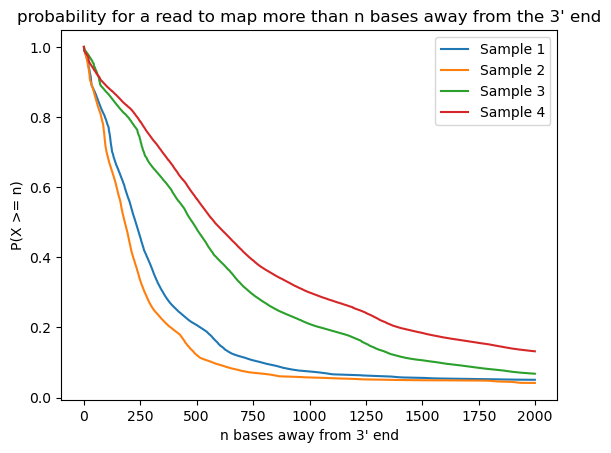

In [56]:
#bin the data
data = {}
for i in range(1,5):
    read_distances_from_3_prime_end = collected_data[i]['read_distances_from_3_prime_end']
    data[i] = np.histogram(read_distances_from_3_prime_end, bins = len(read_distances_from_3_prime_end))[0] / len(read_distances_from_3_prime_end)
for i in range(1,5):
    plt.plot(np.flip(np.cumsum(np.flip(data[i])))[:2000], label=f'Sample {i}')


plt.title("probability for a read to map more than n bases away from the 3' end")
plt.xlabel("n bases away from 3' end")
plt.ylabel("P(X >= n)")
plt.legend()

From here we try to post process the statistics somehow

In [ ]:
norm_matrices = {}
for i in range(1,5):
    poly_A_appearences = collected_data[i]['poly_A_appearences']
    read_appearances_from_poly_A = collected_data[i]['read_appearances_from_poly_A']

    max_poly_A_streak = max(poly_A_appearences.keys())
    max_distance_from_streak = 0
    for streak_length in range(1, max_poly_A_streak+1):
        try:
            max_dist_for_current_length = max(list(read_appearances_from_poly_A.get(streak_length, {}).keys()))
        except ValueError:
            max_dist_for_current_length = 0
        max_distance_from_streak = max(max_distance_from_streak,  max_dist_for_current_length)
    n_appearances_of_streaks = np.zeros(max_poly_A_streak)
    n_appearances_of_reads_from_streaks = np.zeros((max_poly_A_streak, max_distance_from_streak+1))
    for streak_length in range(1, max_poly_A_streak+1):
        n_appearances_of_streaks[streak_length-1] = poly_A_appearences.get(streak_length, 0)
        for distance_from_streak in range(0, max_distance_from_streak):
            n_appearances_of_reads_from_streaks[streak_length-1, distance_from_streak] = read_appearances_from_poly_A.get(streak_length, {}).get(distance_from_streak, 0)

    #get probabilities of read less than m away from a k length poly-A streak
    n_appearences_of_reads_from_streaks_length_k_less_than_m_bases_away = np.cumsum(n_appearances_of_reads_from_streaks, axis = 1)
    norm_matrix = n_appearences_of_reads_from_streaks_length_k_less_than_m_bases_away / (n_appearances_of_streaks[:, np.newaxis] + 10e-10)
    norm_matrices[i] = norm_matrix
    n_rows = 100
    plt.figure()
    plt.imshow(norm_matrix[:n_rows, :2000], cmap='Reds', aspect='auto')
    plt.yticks(np.arange(1, n_rows, 5))
    plt.colorbar()

In [120]:
norm_matrices[1][1]
from scipy.signal import savgol_filter

number of streaks for sample 1: 148131.0
number of streaks for sample 2: 115963.0
number of streaks for sample 3: 120135.0
number of streaks for sample 4: 334965.0


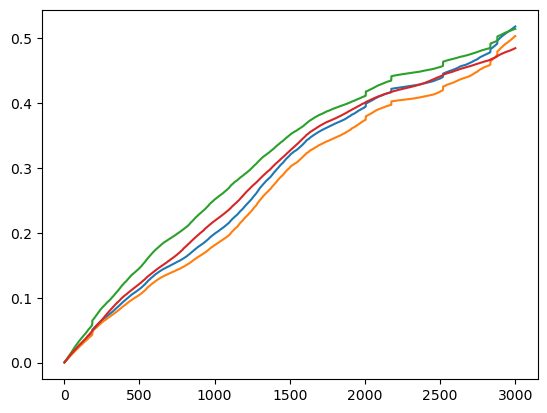

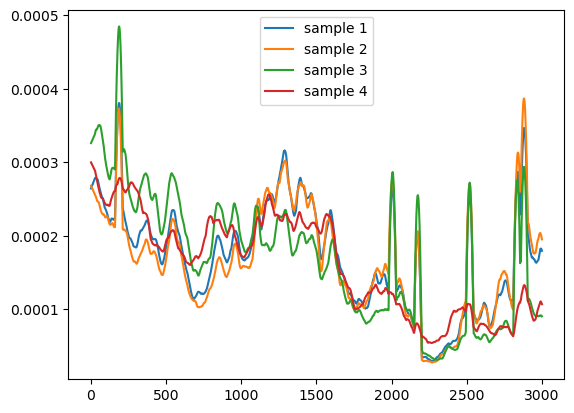

In [131]:
#plot CDFs (PMFs) and empirical pdfs for a given k (length of poly A streak) or a range of such values:
streak_lengths = (10,15) #can be tuple or int; if tuple then sum reads over lengths in the interval
max_bases_away = 3000

max_distance_from_streak = 0
for i in range(1,5):
    poly_A_appearences = collected_data[i]['poly_A_appearences']
    read_appearances_from_poly_A = collected_data[i]['read_appearances_from_poly_A']
    if type(streak_lengths) == int:
        streak_lengths = (streak_lengths, streak_lengths)

    #get maximum distance from a read from any given streak (the maximal value of the X axis - i.e. the upper bound for the support of our distribution)
    for streak_length in range(streak_lengths[0], streak_lengths[1] + 1):
        try:
            max_dist_for_current_length = max(list(read_appearances_from_poly_A.get(streak_length, {}).keys()))
        except ValueError:
            max_dist_for_current_length = 0
        max_distance_from_streak = max(max_distance_from_streak,  max_dist_for_current_length)

    #now build matrices for plotting
    n_appearances_of_streaks = np.zeros(streak_lengths[1] - streak_lengths[0] + 1)
    n_appearances_of_reads_from_streaks = np.zeros(((streak_lengths[1] - streak_lengths[0] + 1), max_distance_from_streak+1))
    for j,  streak_length in enumerate(range(streak_lengths[0], streak_lengths[1] + 1)):
        n_appearances_of_streaks[j] = poly_A_appearences.get(streak_length, 0)
        for distance_from_streak in range(0, max_distance_from_streak):
            n_appearances_of_reads_from_streaks[j, distance_from_streak] = read_appearances_from_poly_A.get(streak_length, {}).get(distance_from_streak, 0)

    n_appearances_of_reads_from_streaks_less_than_k_away = np.cumsum(n_appearances_of_reads_from_streaks, axis = 1)
    pmf = np.sum(n_appearances_of_reads_from_streaks_less_than_k_away, axis = 0) / np.sum(n_appearances_of_streaks)
    pdf = np.gradient(pmf)
    pdf = savgol_filter(pmf, 51, 2, deriv = 1)
    #print((n_appearances_of_streaks))
    plt.figure('pmfs')
    if max_bases_away == None:
        plt.plot(range(1, len(pmf) + 1), pmf, label = f"sample {i}")
    else:
        plt.plot(range(1, max_bases_away + 1), pmf[:max_bases_away], label = f"sample {i}")

    plt.figure('pdfs')
    if max_bases_away == None:
        plt.plot(range(1, len(pdf) + 1), pdf, label = f"sample {i}")
    else:
        plt.plot(range(1, max_bases_away + 1), pdf[:max_bases_away], label = f"sample {i}")

    #plt.plot(range(1, max_bases_away + 1), norm_matrices[i][(streak_length - 1), :max_bases_away], label = f"sample {i}")
    print(f"number of streaks for sample {i}: {sum(n_appearances_of_streaks)}")
plt.legend()
plt.show()

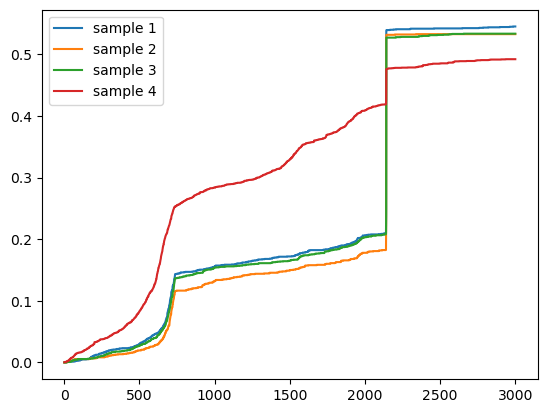

In [ ]:
#plot CDFs (PMFs) and empirical pdfs for a given k (length of poly A streak) or a range of such values:
streak_lengths = 20 #can be tuple or int; if tuple then sum reads over lengths in the interval
max_bases_away = 3000

max_distance_from_streak = 0
for i in range(1,5):
    poly_A_appearences = collected_data[i]['poly_A_appearences']
    read_appearances_from_poly_A = collected_data[i]['read_appearances_from_poly_A']
    if type(streak_lengths == int):
        streak_lengths = (streak_lengths, streak_lengths)
        
    #get maximum distance from a read from any given streak (the maximal value of the X axis - i.e. the upper bound for the support of our distribution)
    for streak_length in range(streak_lengths[0], streak_lengths[1] + 1):
        try:
            max_dist_for_current_length = max(list(read_appearances_from_poly_A.get(streak_length, {}).keys()))
        except ValueError:
            max_dist_for_current_length = 0
        max_distance_from_streak = max(max_distance_from_streak,  max_dist_for_current_length)

    #now build matrices for plotting
    n_appearances_of_streaks = np.zeros(streak_lengths[1] - streak_lengths[0] + 1)
    n_appearances_of_reads_from_streaks = np.zeros(((streak_lengths[1] - streak_lengths[0] + 1), max_distance_from_streak+1))
    for streak_length in range(streak_lengths[0], streak_lengths[1] + 1):
        n_appearances_of_streaks[streak_length-1] = poly_A_appearences.get(streak_length, 0)
        for distance_from_streak in range(0, max_distance_from_streak):
            n_appearances_of_reads_from_streaks[streak_length-1, distance_from_streak] = read_appearances_from_poly_A.get(streak_length, {}).get(distance_from_streak, 0)

    n_appearances_of_reads_from_streaks_less_than_k_away = np.cumsum(n_appearances_of_reads_from_streaks, axis = 1)
    pmf = np.sum(n_appearances_of_reads_from_streaks_less_than_k_away, axis = 0) / np.sum(n_appearances_of_streaks)
    plt.plot(range(1, max_bases_away + 1), pmf[:max_bases_away], label = f"sample {i}")
    #plt.plot(range(1, max_bases_away + 1), norm_matrices[i][(streak_length - 1), :max_bases_away], label = f"sample {i}")
plt.legend()
plt.show()